In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# m2vDroid: Attacking the HinDroid Malware Detector

## INTRODUCTION

Over the past decade, malware has established itself as a constant issue for the Android operating system. In 2018, Symantec reported that they blocked more than 10 thousand malicious Android apps per day, while nearly 3 quarters of Android devices remained on older versions of Android. With billions of active Android devices, millions are only a swipe away from becoming victims. Naturally, automated machine learning-based detection systems have become commonplace solutions as they can parse through thousands of apps in seconds. However, it has been shown that many of these models are vulnerable to adversarial attacks, notably those that add redundant code to malware in an attempt to mislead detectors. 

In our project, we introduce a new model that extends the [Hindroid detection system](https://www.cse.ust.hk/~yqsong/papers/2017-KDD-HINDROID.pdf) by employing node embeddings using [metapath2vec](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf) which we call m2vDroid. We believe that the introduction of node embeddings will improve the performance of our model beyond the capabilities of HinDroid. Second, we attempt to attack these models with adversarial machine learning using a method similar to that proposed in  the paper [Android HIV](https://ieeexplore.ieee.org/document/8782574). Specifically, we aim to find a way to add small changes to malware so that it may evade a detector. We hope that this will serve as a first step to determining the robustness of these models against adversarial attacks.

### Preliminaries
There are a few concepts that we should introduce before we get into details:

- *Definition 1)* A **Heterogeneous Information Network (HIN)** is a graph in which its nodes and edges have different types. 

- *Definition 2)* A **Metapath** is a path within a HIN that follows certain node types. For example, let us define a HIN with a set of node types $T$ and a path $P = n_1 \longrightarrow n_2 \longrightarrow ... \longrightarrow n_{N}$ of length $N$. $P$ follows metapath $M_P = t_1 \longrightarrow t_2 \longrightarrow ... \longrightarrow t_{N}$ if $type(n_i) = t_i$ for all $i \in [1,2,...,N]$.

## PREVIOUS WORKS
### Hindroid
Hindroid is a malware detection system developed in 2017 by Hou, et al and is a significant inspiration  for our model, m2vDroid. In it, they "represent Android apps, related APIs, and their rich relations as a heterogeneous information network" and was one of the first to apply this method for the detection of malware. To build their heterogeneous information network, they unpack and decompile Android apps into the readable `smali` format and extract information for each API call (Notably, their code block, package, and invoke method). With this data, they construct 4 matrices which serve as adjacency matrices for Apps and APIs in the heterogeneous information network:

<table>
    <tr>
        <th colspan=3> <b>Description of Each Matrix</b></th>
    </tr>
    <tr>
        <th><b>G</b></th>
        <th>Element</th>
        <th>Description</th>
    </tr>
    <tr>
        <td><b>A</b></td>
        <td> $a_{i,j}$ </td>
        <td> If $app_i$ contains $API_j$, then $a_{i,j} = 1$;<br> otherwise, $a_{i,j} = 0$.</td>
    </tr>
    <tr>
        <td><b>B</b></td>
        <td> $b_{i,j}$ </td>
        <td> If $API_i$ and $API_j$ co-exist in the same block, then $b_{i,j} = 1$;<br> otherwise, $b_{i,j} = 0$.</td>
    </tr>
    <tr>
        <td><b>P</b></td>
        <td> $p_{i,j}$ </td>
        <td> If $API_i$ and $API_j$ have the same package name, then $p_{i,j} = 1$;<br> otherwise, $p_{i,j} = 0$.</td>
    </tr>
    <tr>
        <td><b>I</b></td>
        <td> $i_{i,j}$ </td>
        <td> If $API_i$ and $API_j$ have the same invocation type, then $i_{i,j} = 1$;<br> otherwise, $i_{i,j} = 0$.</td>
    </tr>
</table>

Using these relationships, they form metapaths between all apps. For example, the metapath $App \xrightarrow{contains}API\xrightarrow{contains^{-1}}App$ which is captured by the $AA^T$ kernel. Other kernels they consider include $ABA^T$, $APA^T$, $ABPB^TA^T$, and $APBP^TA^T$. For $n$ apps, this produces $n \times n$ matrices — for each metapath — where the value at index $[i,j]$ is the number of paths connecting $App_i$ with $App_j$ for that metapath. Therefore, each row in the matrix is the feature vector for an app with the number of metapaths between it and all other apps in the training set. Each matrix then forms a kernel for a support vector machine and with multi-kernel learning they were able to achieve performances ranging from a $0.948$ F1-score to $0.988$ with the multi-kernel model.

### Android HIV
In this paper, the authors, Chen et al., introduce a framework for attacking malware detection models, specifically the MamaDroid and Drebin systems. To perform this, they modified two adversarial attack algorithms: a modified Carlini and Wagner (C&W) attack and a modified Jacobian Saliency Map Attack (JSMA). These modified algorithms were used to generate perturbations that were added into the features of apps so that they were misclassified as benign all while keeping the apps as functional examples of malware. With these methods, they were able to reduce the performance of both the MamaDroid and Drebin malware from detection rates of more than $95\%$ to $1\%$. In our project, we adapt their methods in order to attack the HinDroid system and our model.

## METHODOLOGY
In this section, first, we will describe the details of our proposed model, m2vDroid, and then we will describe the method we used to attack the models in the Adversarial Attack section.

## m2vDroid
m2vDroid is another malware detection model that we implemented that is largely based off HinDroid. However it uses node embeddings for the final vector representations of apps instead of the bag-of-APIs/commuting matrix solution that HinDroid applied.

### Feature extraction
Our ETL pipeline begins with Android apps in the form of APK files. These APKs are unpacked using [Apktool](https://ibotpeaches.github.io/Apktool/) to reveal the contents of the app, but we are primarily concerned with `classes.dex`, the app's bytecode. We decompile the bytecode using [Smali](https://github.com/JesusFreke/smali) into readable `.smali` text files. From here we extract each API call, the app and method it appears in, and the package it is from. This is done for every API in an app and for every app in the dataset, forming a table with the information needed for the next step.

### HIN Construction
Using the data extracted previously, we construct a heterogeneous information network using the [Stellargraph](https://github.com/stellargraph/stellargraph) library. Our HIN contains 4 types of nodes which we define as: 
- $Apps$: Android apps determined by name or md5, i.e. `com.microsoft.excel` or `09d347c6f4d7ec11b32083c0268cc570`.
- $APIs$: APIs determined by their smali representation, i.e. `Lpackage/Class;->method();V`
- $Packages$: the package an API originates from, i.e. `Lpackage`.
- $Methods$: Methods (or "functions") that API calls appear in, i.e. `LclassPackage/class/method();V`.

The distinct nodes for each type correspond to the distinct values of their column in the API data table described earlier. $Apps$ and $APIs$ share an edge if an $API$ is used within an $App$. Likewise $APIs$ and $Methods$ share an edge if a $Method$ contains an $API$. $Packages$ and $APIs$ share an edge if an $API$ originates from a $Package$.

### Metapath2vec
To generate our features, we apply the metapath2vec algorithm on the $App$ nodes of our HIN. That is we 1) perform a random-walk leveraging Stellargraph's `MetaPathRandomWalk` algorithm starting from each app. We follow designated metapaths to generate a "corpus" consisting of nodes in our HIN, then we 2) pass this corpus into the gensim implementation  of the [word2vec](https://arxiv.org/pdf/1301.3781.pdf) model to transform each $App$ into a vector.

After running this ETL on our data, we observed clear clustering after plotting a TSNE transformation of the vectors we generated. For the most, part it seems that this method is able to distinguish between not only malware and non-malware, but can also distinguish between different classes of malware to a reasonable extent. Notably, we have not tested the node2vec or metapath2vec++ algorithms for generating our random walk.

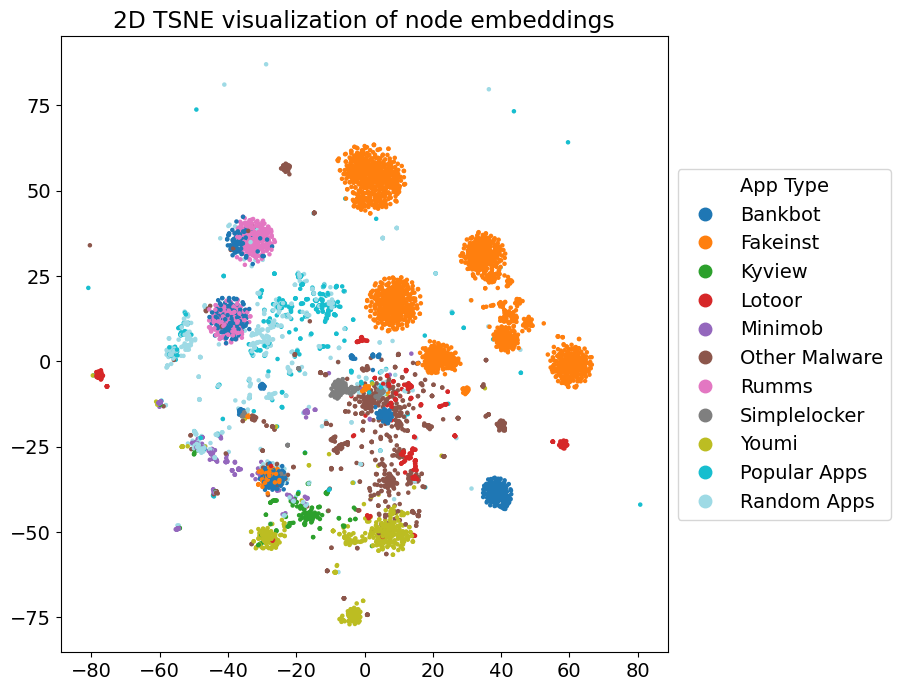

In [11]:
from IPython.display import Image, display, HTML

display(HTML("""
<style>
.jp-OutputArea-child {
    width: 100% !important;
}

table {
    margin: auto !important;
}

</style>
"""))
Image(filename="../data/out/all-apps/2D-plot.png")

### Exploring the Plot
Looking at this plot, we seem to have multiple clusters of apps. We wanted to theorize why these clusters might be occurring  so we compiled descriptions of a few types of malware and some possible explanations for why we see what we see. 

- **BankBot:** a mobile banking trojan that steals banking credentials and payment information, by presenting an overlay window which looks identical to a bank app’s login page, 
- **RuMMs:** a distributed through SMS phishing, and in some cases initiate transactions by contacting financial institutions.
- **Simplelocker:** a ransomware that encrypts the users data, which includes a pop up window that requests a fee to recover data. 
- **Lotoor:** a trojan that tries to manage the data on the system and change the settings on the device.
- **FakeInst:** portrays itself as the real instagram app but will actually send premium SMS text messages once the user installs it. It evolved into many different variations over the years, so the numerous  clusters we see are likely due to the similar versions of it clustering together.

The two distinct BankBot and RuMMs clusters may be explained by them both targeting banking data, as RuMMs initiates transactions and BankBot steals a user’s banking information. Rumms and Bankbot are also both considered trojans. Then there is the general malware cluster defined mostly by the apps from the Other Malware category. What may be contributing to these apps clustering together is that they might share many of the common APIs used for carrying out general malicious activity such as privilege  elevation, data harvesting, opening pops, or modifying system files.

## ADVERSARIAL ATTACK
Our adversarial attack follows many of the techniques applied by Chen, et al. (2018) to attack the MaMaDroid and Drebin models. To perform our attack on HinDroid, we followed their *Scenerio FB* which allowed access only to a blackbox representation of a malware classifier and the feature set of this classifier. In this case, we will be able to query the classifier as we create examples and appropriately add new APIs. The feature set will be the set of distinct APIs derived from our training apps. In our case, the input vector will be the one-hot-encoded set of APIs for the example app. To perform the attack, we modified the constraints of their objective function as such:

$$
min_{\delta}\Vert\delta\Vert^2_2 + c \cdot f(X+\delta) \\
s.t. X + \delta \in \{0,1\}^n \\
\text{and } X_i + \delta_i \ne 1 \text{ if } X_i = 1
$$

where

$$
f(x') = \max\{0, (\max_{i \ne t}{Z(x')_i} - Z(x')_t) \cdot \tau + \kappa\}
$$

To explain, $min_{\delta}\Vert\delta\Vert^2_2 + c \cdot f(X+\delta)$ is the objective function trying to find a perturbations, $\delta$, we can add to the original example, $X$ so that the model misclassifies the resulting app. $X + \delta \in \{0,1\}^n$ simply ensures that we work with the discrete values 0 and 1, since the input to our model and HinDroid is a one-hot-encoded vector for the apps in our dataset. We also want to ensure that we do not remove any APIs from an app as it could likely break the app entirely. We want to avoid this just as the Android HIV authors did. This is covered by $X_i + \delta_i \ne 1 \text{ if } X_i = 1$.

In reality, it wasn't as simple as just changing this function. Working with the discrete one-hot values will not work natively with the C&W algorithm as it was originally constructed for continuous values. This made it straightforward for the Android HIV authors to modify it to work with the probability values, but it does not directly transfer to our problem. To solve this, we modified the *tanh-trick* used by the C&W attack to optimize the perturbations. The trick maps the values of the perturbations into an infinite space to make gradient descent more reliable when boundary constraints are applied (such as limiting the values to be in $[0,1]$). To perform the mapping, the values are scaled to the input range of the $\tanh^{-1}$ function or $[-1,1]$ and then passed through it. What we did was add a scalar $\lambda$ that scales this function dramatically to make the transition between 0 and 1 approximately instantaneous. This was the key to making the algorithm compatible with our discrete values. Of course, it was still possible for the perturbations to fall between 0 and 1, so we were sure to perform a validation step by rounding each example and getting the final output label using the rounded example.

## EXPERIMENT

To evaluate our methods we conducted two tests: The first evaluating the performance of HinDroid against m2vDroid and second evaluating the strength the our adversarial attack.

### m2vDroid Experiment
To test our models, we used a dataset of 6,451 apps. 5,516 of these apps have been deemed malicious through other methods. We will use this as the malware set. For the benign set, we selected 2 categories of apps: popular apps and random apps. Popular apps were selected from the popular category of [apkpure.com](https://apkpure.com/), a Android app marketplace. Random apps were selected at random from the site. While popular apps are unlikely to be malicious, the same cannot be said for random apps. Some estimates believe that up to 5% of the apps could contain malware. Nevertheless, we use the apps to bolster the benign app set as not doing so would make the benign app set negligibly small compared to the malware set. In total, we used 905 apps for the benign set, with 324 popular apps and 581 random apps. Between these apps, there were 6,495,974 distinct API calls, 653,742 packages, and 6,945,506 distinct method declarations.

We then created a training set with one third of the apps, with the remainder becoming the test set, making sure to keep the proportion of each category of app equal. The result is that the training set had a total of 2,535,703 distinct API calls, 273,241 packages, and 2,674,056 distinct method declarations. With these sets, we will compare the performance of m2vDroid against 5 of Hindroid's best performing single-kernel models ($AA^T$, $ABA^T$, $APA^T$, $ABPB^TA^T$, $APBP^TA^T$).

### m2vDroid Parameters
For the metapath walk, we specified a walk length of 60, walking on each of the following metapaths 3 times per $App$ node:
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $App$
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $Method$ $\rightarrow$ $Api$ $\rightarrow$ $App$
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $Package$ $\rightarrow$ $Api$ $\rightarrow$ $App$
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $Package$ $\rightarrow$ $Api$ $\rightarrow$ $Method$ $\rightarrow$ $Api$ $\rightarrow$ $App$
- $App$ $\rightarrow$ $Api$ $\rightarrow$ $Method$ $\rightarrow$ $Api$ $\rightarrow$ $Package$ $\rightarrow$ $Api$ $\rightarrow$ $App$

We chose these metapaths as they are similar to the set formed by the 5 single kernel models of HinDroid that we will be considering.

For word2vec, we used a skip-gram model trained over 10 epochs. We used a window size of 7 so that 2 connected apps could appear in the window even in the longest metapaths. The `min_count` parameter was set to `0` so that all nodes in the metapath walk were incorporated. We also were sure to include negative sampling as part of the process, as negative samples would help further distinguish nodes the are not associated with each other. For this we specified `negative=5` for a final output vector of length 128.

### Adversarial Experiment
To test the adversary, we trained a substitute model on the $AA^T$ kernel for HinDroid. Using this model, we generated examples for 500 apps selected at random from our entire app dataset. We then took these examples and their original inputs and ran them through each kernel of the HinDroid classifier. This would help us determine how well the examples generalize to attacking the other kernels as well as shed insight into the inner workings of HinDroid itself.

As for the parameters of the attack, we used a lambda of 10000, a confidence of 0.0, a c_range of (0.1, 1e10), using 5 binary search steps, and max_iter of 1000. We also set the learning rate to be 0.01. We initialize the perturbations in tanh-space randomly setting approximately 5% of these values to 1. To clarify, this is not equivalent to randomly adding APIs. We found that the algorithm never succeeded if we left the perturbations at 0. Adding these small changes gives inertia to the algorithm and was key to generating successful examples.

## RESULTS
 
### HinDroid vs m2vDroid 
With the final results, we can see that while we still achieved some respectable numbers, m2vDroid struggled to keep up with the HinDroid kernels' performances and it had a pronounced issue with false positives. This may simply be the case that m2vDroid is not as effective as HinDroid or that we may need to further tune the parameters of it. However, considering that some other kernels faced the same issue, albeit with a smaller magnitude, this may be the result of the heavy bias in our dataset. This could also be due to the inclusion of random apps. Recall that a small percentage of these apps may actually be malware but we may have mislabeled them as benign by assuming all random apps were benign to begin with. It may be worth the effort to perform the test again by either excluding random apps or filtering possible malware using another method.

In [2]:
import pandas as pd
pd.read_csv('assets/baseline_performance_chart.csv', index_col=0).style.format({
    'F1': '{0:.3f}',
    'ACC': '{0:.3f}',
    'TPR': '{0:.3f}',
})

,ACC,TPR,F1,TP,TN,FP,FN
m2vDroid,0.950,1.000,0.973,3676,169,202,1
AAT,0.986,0.999,0.992,3674,316,55,3
ABAT,0.976,0.990,0.987,3642,310,61,35
APAT,0.979,0.998,0.989,3670,294,77,7
ABPBTAT,0.986,0.999,0.992,3672,320,51,5
APBPTAT,0.976,0.992,0.987,3647,303,68,30


### Adversarial Attack
After testing the adversarial examples we generated, we were returned the following results. Being that we trained against the $AA^T$ kernel for the test, it is not surprising we see that that the attack was most successful against this kernel, achieving an evasion rate of 97.2%. Malware examples were also able to evade the $APA^T$ and $APBP^TA^T$ kernels with a success rate >99%. Malware examples were fairly ineffective when it came to the $APA^T$ and $ABPB^TA^T$ kernels. It may be that these kernels are more broad with their definition of malware, making it harder for the malware examples to evade them. The inverse might be said for the $APBP^TA^T$ where benign examples struggled to evade the classifier. Overall, we believe these results are incredibly promising for our method and would like to expand them to other kernels as well as our model in the future.

In [15]:
pd.read_csv('assets/attack_success.csv', index_col=0).style.format({
    'AAT': '{0:.1%}',
    'ABAT': '{0:.1%}',
    'APAT': '{0:.1%}',
    'ABPBTAT': '{0:.1%}',
    'APBPTAT': '{0:.1%}'
})

,AAT,ABAT,APAT,ABPBTAT,APBPTAT,Support
Original AAT Label,,,,,,
Benign,80.0%,96.4%,58.2%,96.4%,5.5%,55
Malware,99.3%,1.1%,99.1%,0.2%,99.3%,445
Total,97.2%,11.6%,94.6%,10.8%,89.0%,500


## ACKNOWLEDGEMENTS
- Carlini, Nicholas, and David Wagner. “Towards Evaluating the Robustness of Neural Networks.”, doi:10.1109/sp.2017.49. 
- Chen, Xiao, et al. “Android HIV: A Study of Repackaging Malware for Evading Machine-Learning Detection.” IEEE Transactions on Information Forensics and Security, vol. 15, 2020, pp. 987–1001., doi:10.1109/tifs.2019.2932228. 
- Hou, Shifu, et al. “HinDroid: An Intelligent Android Malware Detection System Based on Structured Heterogeneous Information Network.” 2017, doi:10.1145/3097983.3098026.
- Dong, Yuxiao, et al. “metapath2vec: Scalable Representation Learning for Heterogeneous Networks.” 2017, doi:10.1145/3097983.3098036. 
- APKTool. http://ibotpeaches.github.io/Apktool/.
- Stellargraph. https://github.com/stellargraph/stellargraph
- Gensim. https://radimrehurek.com/gensim/
- PyTorch implementation of Carlini-Wanger's L2 attack. https://github.com/kkew3/pytorch-cw2
- Imbalanced Data Sampler by ufoym. https://github.com/ufoym/imbalanced-dataset-sampler

And to our mentors, Professor Aaron Fraenkel and Shivam Lakhotia, who provided guidance and insight throughout our project.
